### Import all necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

import gensim
from gensim.models.word2vec import Word2Vec

### EDA

In [2]:
#Load the dataset
data=pd.read_csv(r'C:\Users\samyu\Downloads\train.csv', encoding='unicode_escape')
data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [4]:
data.columns

Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)'],
      dtype='object')

In [5]:
data.shape

(27481, 10)

In [6]:
data.dtypes

textID               object
text                 object
selected_text        object
sentiment            object
Time of Tweet        object
Age of User          object
Country              object
Population -2020      int64
Land Area (Km²)     float64
Density (P/Km²)       int64
dtype: object

In [7]:
data.isna().any()

textID              False
text                 True
selected_text        True
sentiment           False
Time of Tweet       False
Age of User         False
Country             False
Population -2020    False
Land Area (Km²)     False
Density (P/Km²)     False
dtype: bool

In [8]:
data['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [9]:
data['sentiment'].nunique()

3

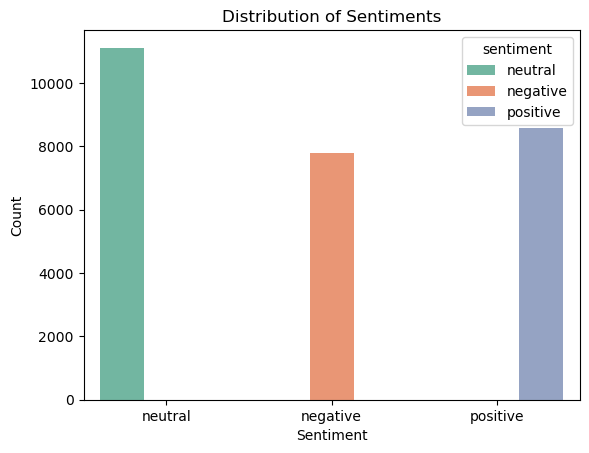

In [10]:
sns.countplot(data=data, x='sentiment', hue='sentiment', palette='Set2')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

plt.show()

### Preprocessing

In [11]:
#Selecting the required features
x= data['selected_text']
y=data['sentiment']

In [12]:
#Removing punctuations
import string

def remove_punctuation(selected_text):
    removed_text = ""
    for char in str(selected_text):
        if char not in string.punctuation:
            removed_text += char
    return removed_text

data['removed_punc'] = data['selected_text'].apply(remove_punctuation)

In [13]:
print(f"Before: {data['selected_text'][0]}\nAfter: {data['removed_punc'][0]}")

Before: I`d have responded, if I were going
After: Id have responded if I were going


In [14]:
#Tokenization
def convert_tokens(selected_text):
    text = str(selected_text).lower()
    tokens = []
    tokens = re.split("\s+",text)
    return tokens

In [15]:
data['Tokens'] = data['removed_punc'].apply(convert_tokens)
print(f"Tokens: {data['Tokens'][0]}")

Tokens: ['id', 'have', 'responded', 'if', 'i', 'were', 'going']


In [16]:
data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),removed_punc,Tokens
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,Id have responded if I were going,"[id, have, responded, if, i, were, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,Sooo SAD,"[sooo, sad]"
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,bullying me,"[bullying, me]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,leave me alone,"[leave, me, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,Sons of,"[sons, of, ]"


In [17]:
#Removing Stopwords
def remove_stopwords(tokens):
  return [token for token in tokens if token not in stopwords.words("english")]

In [18]:
data['removed_stopwords_tokens'] = data['Tokens'].apply(remove_stopwords)
print(f"Before: {data['Tokens'][0]}\nAfter: {data['removed_stopwords_tokens'][0]}")

Before: ['id', 'have', 'responded', 'if', 'i', 'were', 'going']
After: ['id', 'responded', 'going']


In [19]:
#Lemmatization
def lemma_tokens(tokens):
    word_net = WordNetLemmatizer()
    tokens = [word_net.lemmatize(tok) for tok in tokens]
    return tokens

In [20]:
data['lemmatized'] = data['removed_stopwords_tokens'].apply(lemma_tokens)
print(f"Before: {data['removed_stopwords_tokens'][0]}\nAfter: {data['lemmatized'][0]}")

Before: ['id', 'responded', 'going']
After: ['id', 'responded', 'going']


In [21]:
#Return the preprocessed text
def return_sequence(tokens):
  return " ".join([token for token in tokens])

In [22]:
data['pre_processed_text'] = data['lemmatized'].apply(return_sequence)
print(f"Before: {data['removed_stopwords_tokens'][0]}\nAfter: {data['pre_processed_text'][0]}")

Before: ['id', 'responded', 'going']
After: id responded going


In [23]:
data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),removed_punc,Tokens,removed_stopwords_tokens,lemmatized,pre_processed_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,Id have responded if I were going,"[id, have, responded, if, i, were, going]","[id, responded, going]","[id, responded, going]",id responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,Sooo SAD,"[sooo, sad]","[sooo, sad]","[sooo, sad]",sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,bullying me,"[bullying, me]",[bullying],[bullying],bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,leave me alone,"[leave, me, alone]","[leave, alone]","[leave, alone]",leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,Sons of,"[sons, of, ]","[sons, ]","[son, ]",son


### Feature engineering

In [26]:
#Bag of Words
cv = CountVectorizer()
count_matrix = cv.fit_transform(data['pre_processed_text'].values.tolist())
count_matrix.toarray().shape

(27481, 17424)

In [28]:
count_matrix

<27481x17424 sparse matrix of type '<class 'numpy.int64'>'
	with 109852 stored elements in Compressed Sparse Row format>

In [48]:
#TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(data['pre_processed_text'].values.tolist())
tfidf_array = tfidf_matrix.toarray()

In [49]:
tfidf_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
y

0         neutral
1        negative
2        negative
3        negative
4        negative
           ...   
27476    negative
27477    negative
27478    positive
27479    positive
27480     neutral
Name: sentiment, Length: 27481, dtype: object

### Model building

In [39]:
model= MultinomialNB()

In [55]:
X_train, X_test, y_train,y_test = train_test_split(tfidf_array,y,test_size=0.3)
model.fit(X_train,y_train)

MultinomialNB()

In [56]:
y_pred= model.predict(X_test)

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.7746513038204973
Precision: 0.7915746609144279
Recall: 0.7746513038204973


In [58]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1358  731  234]
 [ 135 2984  220]
 [  53  485 2045]]


### The accuracy of the model is 77%